In [ ]:
!pip -q uninstall -y numpy pandas scipy scikit-learn transformers tokenizers accelerate datasets evaluate safetensors huggingface-hub || true

# Colab uyumlu core stack
!pip -q install "numpy==1.26.4" "pandas==2.2.2" "scipy==1.13.1" "scikit-learn==1.5.2"

print("✅ Core pinned. NOW: Runtime → Restart runtime")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires datasets, which is not installed.
torchtune 0.6.1 requires huggingface_hub[hf_transfer], which is not installed.
torchtune 0.6.1 requires safetensors, which is not installed.
torchtune 0.6.1 requires tokenizers, which is not installed.
gradio 5.50.0 requires huggingface-hub<2.0,>=0.33.5, which is not installed.
sentence-transformers 5.2.0 requires huggingface-hub>=0.20.0, which is not installed.
sentence-transformers 5.2.0 requires transformers<6.0.0,>=4.41.0, which is not installed.
peft 0.18.0 requires accelerate>=0.21.0, which is not installed.
peft 0.18.0 requires huggingface_hub>=0.25.0, which is not installed.
peft 0.18.0 requires safetensors, which is not installed.
peft 0.18.0 requires transformers, which is not installed.
diffusers 0.36.0 requires huggingface-hub<2.0,>=0.34.0, whi

In [ ]:
import numpy as np, pandas as pd
print("numpy:", np.__version__)
print("pandas:", pd.__version__)


numpy: 1.26.4
pandas: 2.2.2


In [ ]:
!pip -q install "huggingface-hub==0.24.6" "safetensors>=0.4.3"
!pip -q install "tokenizers==0.19.1" "accelerate==0.33.0" "transformers==4.44.2"

print("✅ Transformers installed. NOW: Runtime → Restart runtime")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 8.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires datasets, which is not installed.
torchtune 0.6.1 requires tokenizers, which is not installed.
sentence-transformers 5.2.0 requires transformers<6.0.0,>=4.41.0, which is not installed.
peft 0.18.0 requires accelerate>=0.21.0, which is not installed.
peft 0.18.0 requires transformers, which is not installed.
gradio 5.50.0 requires huggingface-hub<2.0,>=0.33.5, but you have huggingface-hub 0.24.6 which is incompatible.
peft 0.18.0 requires huggingface_hub>=0.25.0, but you have huggingface-hub 0.24.6 which is incompatible.
diffusers 0.36.0 requires huggingface-hub<2.0,>=0.34.0, but you have huggingface-hub 0.24.6 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the p

In [ ]:
import numpy as np, pandas as pd
import transformers, accelerate
import huggingface_hub

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("transformers:", transformers.__version__)
print("accelerate:", accelerate.__version__)
print("huggingface_hub:", huggingface_hub.__version__)
print("✅ Imports OK")


numpy: 1.26.4
pandas: 2.2.2
transformers: 4.44.2
accelerate: 0.33.0
huggingface_hub: 0.24.6
✅ Imports OK


In [ ]:
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support

RANDOM_STATE = 42
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 4)

from google.colab import drive
drive.mount("/content/drive")

BASE_DIR = "/content/drive/MyDrive/Semeval_Polar"
DATA_DIR = os.path.join(BASE_DIR, "Data")
OUT_DIR  = os.path.join(BASE_DIR, "Submissions")
os.makedirs(OUT_DIR, exist_ok=True)

TRAIN_PATH = os.path.join(DATA_DIR, "tur_subtask2.csv")
TEST_PATH  = os.path.join(DATA_DIR, "tur_subtask2_test.csv")

print("TRAIN exists?", os.path.exists(TRAIN_PATH), TRAIN_PATH)
print("TEST  exists?", os.path.exists(TEST_PATH),  TEST_PATH)
print("OUT_DIR:", OUT_DIR)


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TRAIN exists? True /content/drive/MyDrive/Semeval_Polar/Data/tur_subtask2.csv
TEST  exists? True /content/drive/MyDrive/Semeval_Polar/Data/tur_subtask2_test.csv
OUT_DIR: /content/drive/MyDrive/Semeval_Polar/Submissions
Device: cuda


In [ ]:
URL_RE     = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#\w+")
MULTI_WS   = re.compile(r"\s+")

def normalize_text(s: str) -> str:
    s = str(s).lower()
    s = URL_RE.sub(" <URL> ", s)
    s = MENTION_RE.sub(" <USER> ", s)
    s = HASHTAG_RE.sub(" <HASHTAG> ", s)
    s = MULTI_WS.sub(" ", s).strip()
    return s


In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv(TRAIN_PATH)

required = {"id", "text"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df["text"] = df["text"].astype(str).str.strip()
df = df[df["text"].str.len() > 0].copy()
df["text_norm"] = df["text"].apply(normalize_text)

label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
missing_labels = [c for c in label_cols if c not in df.columns]
if missing_labels:
    raise ValueError(f"Missing label columns: {missing_labels}")

df2 = df.copy()
if "polarization" in df2.columns:
    before = len(df2)
    df2["polarization"] = pd.to_numeric(df2["polarization"], errors="coerce")
    df2 = df2[df2["polarization"] == 1].copy()
    print(f"Filtered polarization==1: {before} -> {len(df2)}")
else:
    print("No 'polarization' column (OK).")

X = df2["text_norm"].tolist()
Y = df2[label_cols].apply(pd.to_numeric, errors="coerce").fillna(0).astype(int).values

print("X:", len(X), "| Y:", Y.shape)
print("Positives:", {c:int(Y[:,i].sum()) for i,c in enumerate(label_cols)})
display(df2[["id","text"] + label_cols].head(3))


No 'polarization' column (OK).
X: 2364 | Y: (2364, 5)
Positives: {'political': 1057, 'racial/ethnic': 400, 'religious': 360, 'gender/sexual': 113, 'other': 114}


,id,text,political,racial/ethnic,religious,gender/sexual,other
0,tur_153d607a6d1a1130e696a94db6588075,Çıldırmam an meselesi Ben eskiden dövme yaptır...,0,0,0,0,0
1,tur_67a124df33f922df9430d8510716173f,2 Yurtlarını işgal ettiği mazlum v e masum Fil...,1,1,1,0,0
2,tur_0b8d62766d1198185bda9f3940e2d121,@USER Bereket Versin. İHA’ dan ateş edildiğind...,0,0,0,0,0


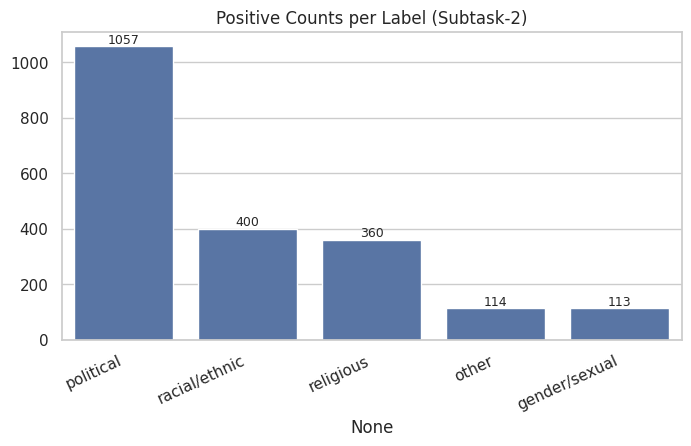

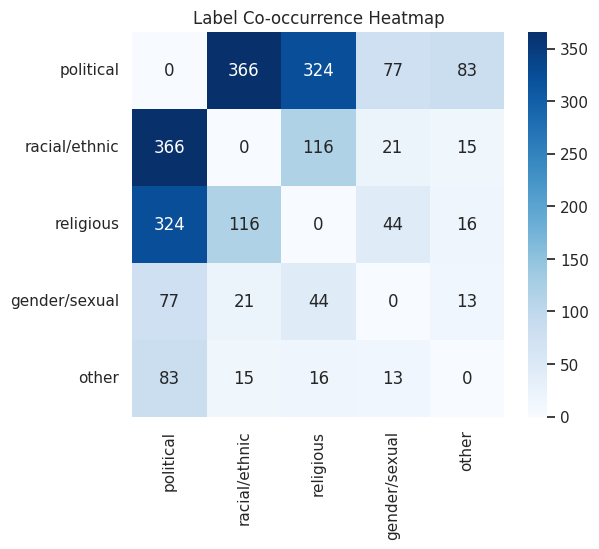

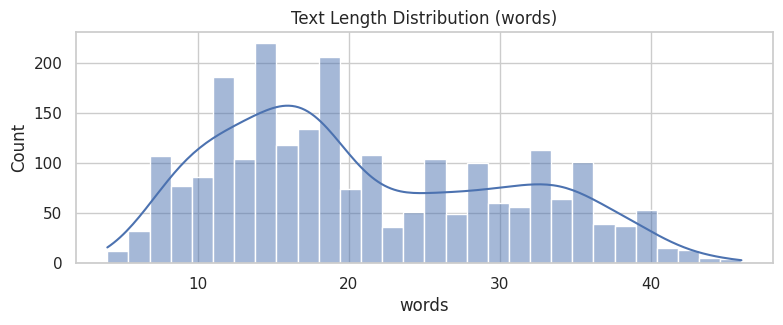

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 4)

# Label positive counts
pos_counts = pd.Series({c: int(Y[:, i].sum()) for i, c in enumerate(label_cols)}).sort_values(ascending=False)

plt.figure(figsize=(8,4))
ax = sns.barplot(x=pos_counts.index, y=pos_counts.values)
plt.title("Positive Counts per Label (Subtask-2)")
plt.xticks(rotation=25, ha="right")
for i, v in enumerate(pos_counts.values):
    ax.text(i, v + max(pos_counts.values)*0.01, str(v), ha="center", fontsize=9)
plt.show()

# Co-occurrence heatmap
cooc = (Y.T @ Y).astype(int)
np.fill_diagonal(cooc, 0)
plt.figure(figsize=(6,5))
sns.heatmap(cooc, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_cols, yticklabels=label_cols)
plt.title("Label Co-occurrence Heatmap")
plt.show()

# Text length distribution
lens = pd.Series([len(t.split()) for t in X])
plt.figure(figsize=(9,3))
sns.histplot(lens, bins=30, kde=True)
plt.title("Text Length Distribution (words)")
plt.xlabel("words")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

X_train, X_dev, Y_train, Y_dev = train_test_split(
    X, Y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", len(X_train), "Dev:", len(X_dev))


Train: 1891 Dev: 473


In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer

MODEL_NAME = "dbmdz/bert-base-turkish-cased"  # TR için iyi

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class MultiLabelTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=192):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

MAX_LEN = 256  # score için sonra 256 deneriz
train_ds = MultiLabelTextDataset(X_train, Y_train, tokenizer, max_len=MAX_LEN)
dev_ds   = MultiLabelTextDataset(X_dev,   Y_dev,   tokenizer, max_len=MAX_LEN)

print("Datasets ready ✅", len(train_ds), len(dev_ds))


Datasets ready ✅ 1891 473


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from transformers import AutoModelForSequenceClassification

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_cols),
    problem_type="multi_label_classification"
).to(device)

print("Model ready ✅")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda
Model ready ✅


In [ ]:
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup

torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
dev_loader   = DataLoader(dev_ds,   batch_size=16, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 4
total_steps = num_epochs * len(train_loader)
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

print("steps:", total_steps, "| warmup:", warmup_steps)


steps: 711 | warmup: 71


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def eval_probs(model, loader):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            labels = batch["labels"].cpu().numpy()
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)
            logits = out.logits.detach().cpu().numpy()
            all_logits.append(logits)
            all_labels.append(labels)
    logits = np.vstack(all_logits)
    labels = np.vstack(all_labels)
    probs  = sigmoid_np(logits)
    return probs, labels

best_macro = -1
best_state = None

train_losses, dev_macros, dev_micros = [], [], []

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch)
        loss = out.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / max(1, len(train_loader))
    train_losses.append(avg_loss)

    P_dev, Yd = eval_probs(model, dev_loader)
    Y_pred05 = (P_dev >= 0.5).astype(int)

    micro = f1_score(Yd, Y_pred05, average="micro", zero_division=0)
    macro = f1_score(Yd, Y_pred05, average="macro", zero_division=0)
    dev_micros.append(micro)
    dev_macros.append(macro)

    print(f"Epoch {epoch}/{num_epochs} | train loss={avg_loss:.4f} | dev micro@0.5={micro:.4f} | dev macro@0.5={macro:.4f}")

    if macro > best_macro:
        best_macro = macro
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

print("\nBest dev macro@0.5:", round(best_macro, 4))


Epoch 1/3 | train loss=0.1787 | dev micro@0.5=0.6530 | dev macro@0.5=0.4597
Epoch 2/3 | train loss=0.1786 | dev micro@0.5=0.6530 | dev macro@0.5=0.4597
Epoch 3/3 | train loss=0.1794 | dev micro@0.5=0.6530 | dev macro@0.5=0.4597

Best dev macro@0.5: 0.4597


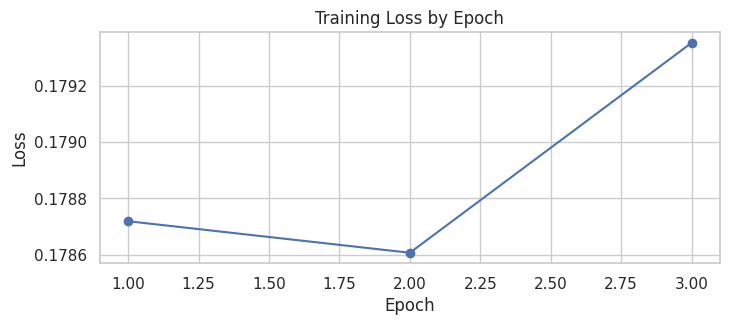

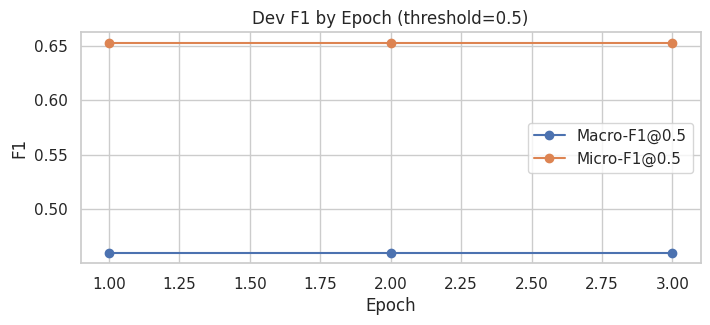

In [ ]:
plt.figure(figsize=(8,3))
plt.plot(range(1, len(train_losses)+1), train_losses, marker="o")
plt.title("Training Loss by Epoch")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(8,3))
plt.plot(range(1, len(dev_macros)+1), dev_macros, marker="o", label="Macro-F1@0.5")
plt.plot(range(1, len(dev_micros)+1), dev_micros, marker="o", label="Micro-F1@0.5")
plt.title("Dev F1 by Epoch (threshold=0.5)")
plt.xlabel("Epoch"); plt.ylabel("F1")
plt.legend()
plt.show()


Best thresholds: {'political': 0.12, 'racial/ethnic': 0.36, 'religious': 0.28, 'gender/sexual': 0.12, 'other': 0.16}
Dev Micro-F1 tuned: 0.7117
Dev Macro-F1 tuned: 0.6058


,label,precision,recall,f1,support,thr
0,political,0.712727,0.878924,0.787149,223,0.12
1,racial/ethnic,0.753623,0.675325,0.712329,77,0.36
2,religious,0.637681,0.611111,0.624113,72,0.28
3,gender/sexual,0.444444,0.640000,0.524590,25,0.12
4,other,0.571429,0.285714,0.380952,28,0.16


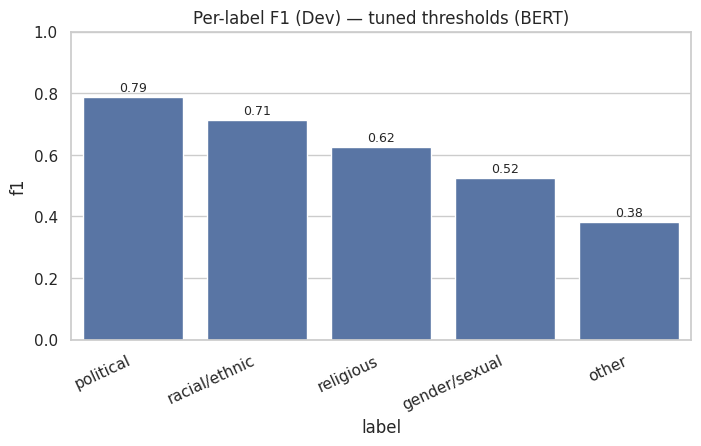

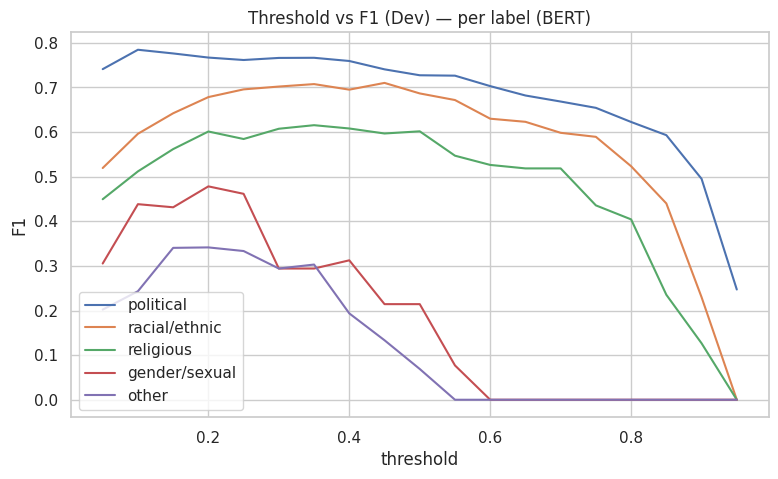

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# load best epoch
model.load_state_dict(best_state)

P_dev, Yd = eval_probs(model, dev_loader)

def best_thresholds_per_label(P, Y_true, grid=None):
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    L = Y_true.shape[1]
    best_thr = np.zeros(L)
    best_f1  = np.zeros(L)

    for j in range(L):
        yj = Y_true[:, j]
        if yj.sum() == 0:
            best_thr[j] = 0.5
            best_f1[j]  = 0.0
            continue
        f1s = [f1_score(yj, (P[:, j] >= t).astype(int), zero_division=0) for t in grid]
        k = int(np.argmax(f1s))
        best_thr[j] = float(grid[k])
        best_f1[j]  = float(f1s[k])

    return best_thr, best_f1

thr, best_f1_each = best_thresholds_per_label(P_dev, Yd)

Y_pred_thr = (P_dev >= thr).astype(int)

micro_t = f1_score(Yd, Y_pred_thr, average="micro", zero_division=0)
macro_t = f1_score(Yd, Y_pred_thr, average="macro", zero_division=0)

print("Best thresholds:", {label_cols[i]: round(thr[i], 2) for i in range(len(label_cols))})
print("Dev Micro-F1 tuned:", round(micro_t, 4))
print("Dev Macro-F1 tuned:", round(macro_t, 4))

p, r, f1, s = precision_recall_fscore_support(Yd, Y_pred_thr, average=None, zero_division=0)
rep = pd.DataFrame({"label": label_cols, "precision": p, "recall": r, "f1": f1, "support": s, "thr": thr}).sort_values("f1", ascending=False)
display(rep)

plt.figure(figsize=(8,4))
ax = sns.barplot(data=rep, x="label", y="f1")
plt.title("Per-label F1 (Dev) — tuned thresholds (BERT)")
plt.ylim(0, 1)
plt.xticks(rotation=25, ha="right")
for i, row in enumerate(rep.itertuples()):
    ax.text(i, row.f1 + 0.02, f"{row.f1:.2f}", ha="center", fontsize=9)
plt.show()

grid = np.linspace(0.05, 0.95, 19)
plt.figure(figsize=(9,5))
for j, lab in enumerate(label_cols):
    yj = Yd[:, j]
    if yj.sum() == 0:
        continue
    f1s = [f1_score(yj, (P_dev[:, j] >= t).astype(int), zero_division=0) for t in grid]
    plt.plot(grid, f1s, label=lab)
plt.title("Threshold vs F1 (Dev) — per label (BERT)")
plt.xlabel("threshold"); plt.ylabel("F1")
plt.legend()
plt.show()


In [ ]:
# Load test
df_test = pd.read_csv(TEST_PATH)

if "text" not in df_test.columns:
    raise ValueError("Test must contain 'text' column")

df_test["text"] = df_test["text"].astype(str).str.strip()
df_test = df_test[df_test["text"].str.len() > 0].copy()
df_test["text_norm"] = df_test["text"].apply(normalize_text)

if "id" not in df_test.columns:
    df_test["id"] = np.arange(len(df_test))

test_ds = MultiLabelTextDataset(
    df_test["text_norm"].tolist(),
    np.zeros((len(df_test), len(label_cols))),  # dummy labels
    tokenizer,
    max_len=MAX_LEN
)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

P_test, _ = eval_probs(model, test_loader)
Y_test_pred = (P_test >= thr).astype(int)

sub = pd.DataFrame({"id": df_test["id"]})
for j, lab in enumerate(label_cols):
    sub[lab] = Y_test_pred[:, j].astype(int)

out_path = os.path.join(OUT_DIR, "subtask2_tr_bert_predictions.csv")
sub.to_csv(out_path, index=False)

print("Saved:", out_path)
display(sub.head(10))


Saved: /content/drive/MyDrive/Semeval_Polar/Submissions/subtask2_tr_bert_predictions.csv


,id,political,racial/ethnic,religious,gender/sexual,other
0,tur_51d5ae56681ac60f71111d88cce7c322,0,0,0,0,0
1,tur_a942b7b57ea21f83cba49c05b3a8dc06,0,0,0,0,0
2,tur_2560161367a0747f32070ba1a54be275,1,0,1,0,0
3,tur_2a45e8c804463256a9dc04328fa867c1,0,0,0,0,0
4,tur_77bd1dd03a347a23f64ae022ad17f53a,1,0,0,0,0
5,tur_ad585591cb519e07dbe602ce07c390fc,1,1,0,0,0
6,tur_f376d5c18b33dd5056271da352c400b4,1,1,1,0,0
7,tur_2ae6522870f36f45c728cff04d381fdc,0,0,0,0,0
8,tur_f0cf95b93214f3a7030187151b2ad23f,0,0,0,0,0
9,tur_e93d64ab0054e0c3b4920f0e191c3022,1,1,0,0,0


In [ ]:
import pandas as pd
import os

sub_path = os.path.join(OUT_DIR, "subtask2_tr_bert_predictions.csv")
sub = pd.read_csv(sub_path)

print("shape:", sub.shape)
print("columns:", list(sub.columns))
print(sub.head(5))

# 0/1 kontrol
for c in sub.columns:
    if c == "id":
        continue
    vals = set(sub[c].unique().tolist())
    print(c, vals)


shape: (115, 6)
columns: ['id', 'political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
                                     id  political  racial/ethnic  religious  \
0  tur_51d5ae56681ac60f71111d88cce7c322          0              0          0   
1  tur_a942b7b57ea21f83cba49c05b3a8dc06          0              0          0   
2  tur_2560161367a0747f32070ba1a54be275          1              0          1   
3  tur_2a45e8c804463256a9dc04328fa867c1          0              0          0   
4  tur_77bd1dd03a347a23f64ae022ad17f53a          1              0          0   

   gender/sexual  other  
0              0      0  
1              0      0  
2              0      0  
3              0      0  
4              0      0  
political {0, 1}
racial/ethnic {0, 1}
religious {0, 1}
gender/sexual {0, 1}
other {0, 1}


In [ ]:
label_cols = ["political","racial/ethnic","religious","gender/sexual","other"]
row_sums = sub[label_cols].sum(axis=1)

print("Rows with ALL ZERO labels:", int((row_sums==0).sum()), "/", len(sub))
print("Rows with at least 1 label:", int((row_sums>0).sum()), "/", len(sub))

sub[row_sums==0].head(10)


Rows with ALL ZERO labels: 43 / 115
Rows with at least 1 label: 72 / 115


,id,political,racial/ethnic,religious,gender/sexual,other
0,tur_51d5ae56681ac60f71111d88cce7c322,0,0,0,0,0
1,tur_a942b7b57ea21f83cba49c05b3a8dc06,0,0,0,0,0
3,tur_2a45e8c804463256a9dc04328fa867c1,0,0,0,0,0
7,tur_2ae6522870f36f45c728cff04d381fdc,0,0,0,0,0
8,tur_f0cf95b93214f3a7030187151b2ad23f,0,0,0,0,0
10,tur_fd3f90c54829e5139011569d8114d308,0,0,0,0,0
11,tur_d0dc12522d7ef1ba6e5f343865d5b45c,0,0,0,0,0
14,tur_f6f8ebd3305b20989fa12c6e9683111b,0,0,0,0,0
16,tur_ea1f66195f9545aa2b5673b4ffecece0,0,0,0,0,0
28,tur_162aeffed9905d29b8d20d3fc1b3139b,0,0,0,0,0


political        71
religious        25
racial/ethnic    19
gender/sexual    11
other             3
dtype: int64


<Axes: title={'center': 'Predicted Positive Counts (Test)'}>

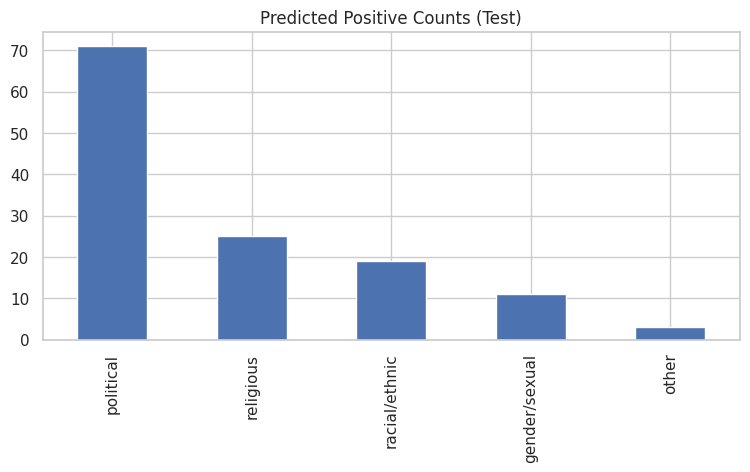

In [ ]:
pred_counts = sub[label_cols].sum().sort_values(ascending=False)
print(pred_counts)

pred_counts.plot(kind="bar", title="Predicted Positive Counts (Test)")


In [ ]:
import pandas as pd

ablation = pd.DataFrame([
    {"Model":"TF-IDF+LR", "Tuning":"@0.5", "Micro-F1":0.5785, "Macro-F1":0.3239},
    {"Model":"BERT (TR)", "Tuning":"tuned", "Micro-F1":0.6159, "Macro-F1":0.5022},
    {"Model":"BERT (TR)", "Tuning":"len256+ep4+grid99", "Micro-F1":0.7117, "Macro-F1":0.6058},
]).sort_values("Macro-F1", ascending=False)

ablation


,Model,Tuning,Micro-F1,Macro-F1
2,BERT (TR),len256+ep4+grid99,0.7117,0.6058
1,BERT (TR),tuned,0.6159,0.5022
0,TF-IDF+LR,@0.5,0.5785,0.3239
